# Árboles de decision para `German.data`
`

Modifique los metodos para el arbol de decision, para poder utilizarlo para classificación. Y apliquelo en los datos de `titanic.csv`

In [1]:
column_name = ['checking', 'duration_', 'history', 'purpose', 'amount_', 'savings',
               'employment', 'installment_', 'personal', 'guarantors', 'recidence_', 
               'property', 'age_', 'other', 'housing', 'credits_',
               'job', 'liable_', 'telephone', 'foreign', 'is_good']
import pandas as pd
import numpy as np
# from scipy.special import expit
%matplotlib inline
import matplotlib.pyplot as plt
#"/media/ibu/SHARED/repos/Credit/data/german.data"
gdata=pd.read_csv("../data/german.data", sep=" ",header = None)
gdata.columns = column_name;
gdat = pd.get_dummies(gdata, drop_first = True).dropna()
# gdat.head()

,duration_,amount_,installment_,recidence_,age_,credits_,liable_,is_good,checking_A12,checking_A13,...,property_A124,other_A142,other_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_A202
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,1,0,0,1,0,1,0
1,48,5951,2,2,22,1,1,2,1,0,...,0,0,1,1,0,0,1,0,0,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,1,0,1,0,0,0,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,0,1,0,1,0,1,0,0,0
4,24,4870,3,4,53,2,2,2,0,0,...,1,0,1,0,1,0,1,0,0,0


## Gini Index
$$ G = \sum_{k=1}^K p_{mk} (1 - p_{mk})$$

In [2]:
# Un árbol esta definido por la siguiente estructura
# {'left': None, 'right': None, 'df': df, 'rss': 0}

def _gini_index(df, y):
    """
    Calculate gini_index R, using the target y.
    """
    categories = df[y].unique()
    gini_index = 0
    max_count = -float('inf')
    yhat = None
    for category in categories:
        category_count = (df[y] == category).sum()
        pmk = category_count / len(df)
        gini_index += pmk * (1 - pmk)
        if max_count < category_count:
            max_count = category_count
            yhat = category
    return gini_index, yhat

# _gini_index(gdat, 'is_good')

(0.41821234567901233, 1)

In [3]:
def _binary_splitting(df, y, x_j):
    """
    Find the best split using the predictor x_j. 
    """
    cut_values = sorted(set(df[x_j]))
    min_s = None
    min_rss, _ = _gini_index(df, y)
    for i in range(len(cut_values) - 1):
        s = (cut_values[i] + cut_values[i+1]) / 2
    
        left_df = df[df[x_j] < s ]
        right_df = df[df[x_j] >= s]
        left_rss, _ = _gini_index(left_df, y)
        right_rss, _ = _gini_index(right_df , y)
        
        # Weighted sum of impurity
        rss = (left_rss*len(left_df) + right_rss*len(right_df))/len(df)
         
        if rss < min_rss:
            min_s = s
            min_rss = rss

    split = {
        'rss': min_rss,
        's': min_s,
        'x_j': x_j,
        'left_df': df[df[x_j] < min_s ],
        'right_df': df[df[x_j] >= min_s]
    }
    return split

# _binary_splitting(gdat, 'is_good', 'amount_')

In [4]:
def _recursive_binary_splitting(df, y, predictors):
    """
    Select the best variable to reduce the
    residual square sum from predictors.
    """
    assert(len(predictors) > 0) # You should have at least one predictor
    min_split = None
    min_rss = float('inf')
    for x_j in predictors:
        split = _binary_splitting(df, y, x_j)
        if split['rss'] < min_rss:
            min_split = split
            min_rss = split['rss']
     
    return {
        'rss': min_rss,
        's': min_split['s'],
        'x_j': min_split['x_j'],
        'left_df': min_split['left_df'],
        'right_df': min_split['right_df']
    }


predict = gdat.columns.values.tolist()
predict.remove('amount_')
predict.remove('is_good')
# _recursive_binary_splitting(gdat, 'is_good',[lista[0]])


In [5]:
def _make_tree(df, y):
    rss, yhat = _gini_index(df, y)
    return {'left': None, 'right':None, 
            'rss': rss,
            'yhat': yhat,
            'df': df,
            'y': y}

def _grow_tree(tree, predictors, min_points_per_leaf=5):
    """
    Recursively divide tree using the split that
    minimize rss. It stops when the region have
    less than 5 elements.
    """
    if len(tree['df']) <= min_points_per_leaf:
        return tree
    
    split = _recursive_binary_splitting(tree['df'], tree['y'], predictors)
    if split['s'] is None:
        return tree
    left_tree = _make_tree(split['left_df'], tree['y'])
    right_tree = _make_tree(split['right_df'],  tree['y'])

    _grow_tree(left_tree, predictors, min_points_per_leaf=min_points_per_leaf)
    _grow_tree(right_tree, predictors, min_points_per_leaf=min_points_per_leaf)
    
    tree['left'] = left_tree
    tree['right'] = right_tree
    tree['x_j'] = split['x_j']
    tree['s'] = split['s']
    
    return tree

DE_tree = _make_tree(gdat, 'is_good')
_grow_tree(DE_tree,predict,5);

In [6]:
def print_tree(tree, pad=0):
    print('{}rss'.format(' '*pad), tree['rss'], tree['yhat'])
    if tree['left']:
        print_tree(tree['left'], pad=pad+1)
    if tree['right']:
        print_tree(tree['right'], pad=pad+1)
# print_tree(DE_tree)

In [15]:
def _is_leaf(tree):
    """
    Return if a given tree is a leaf.
    """
    return not tree['left'] and not tree['right']

def _tree_rss(tree):
    """
    Calculate the total rss of a tree: the sum of the rss of
    all leaves.
    """
    if _is_leaf(tree):
        return tree['rss']

    wsum = len(tree['left']['df']) * _tree_rss(tree['left']) \
             + len(tree['right']['df']) * _tree_rss(tree['right'])
    return wsum/len(tree['df'])

# _tree_rss(DE_tree)

In [16]:
def _count_leafs(tree):
    """
    Return the number of leaves in the tree.
    """
    if _is_leaf(tree):
        return 1
    
    return _count_leafs(tree['left']) + _count_leafs(tree['right'])

# _count_leafs(DE_tree)

In [9]:
def _is_last_branch(tree):
    """
    Return if a given tree is the last branch, i.e. both 
    subtrees are leaves.
    """
    return _is_leaf(tree['left']) and _is_leaf(tree['right'])

def _find_min_deltarss(tree):
    """
    Find the tree that reduces for which the split reduces
    the least the rss.
    """
    if _is_last_branch(tree):
        return tree['rss'] - _tree_rss(tree), tree
    
    is_left_leaf = _is_leaf(tree['left'])
    is_right_leaf = _is_leaf(tree['right'])
    
    if is_left_leaf and not is_right_leaf:
        return _find_min_deltarss(tree['right'])
    elif not is_left_leaf and is_right_leaf:
        return _find_min_deltarss(tree['left'])
    
    deltarss_left, left_tree_branch = _find_min_deltarss(tree['left'])
    deltarss_right, right_tree_branch = _find_min_deltarss(tree['right'])
    
    if deltarss_left < deltarss_right:
        return deltarss_left, left_tree_branch
    else:
        return deltarss_right, right_tree_branch


# _find_min_deltarss(DE_tree)

In [10]:
from copy import deepcopy

def _prune_tree(tree, alpha):
    current_tree = deepcopy(tree)
    min_cc_tree = deepcopy(current_tree)
    min_cc = _tree_rss(current_tree) + alpha * _count_leafs(current_tree)
    while not _is_leaf(current_tree):
        delta_rss, prune_tree = _find_min_deltarss(current_tree)
        prune_tree['left'] = None
        prune_tree['right'] = None
        cc = _tree_rss(current_tree) + alpha * _count_leafs(current_tree)
        #print(cc, min_cc, cc < min_cc)
        if cc < min_cc:
            min_cc = cc
            min_cc_tree = deepcopy(current_tree)
    cc = _tree_rss(current_tree) + alpha * _count_leafs(current_tree)
    if cc < min_cc:
        min_cc = cc
        min_cc_tree = deepcopy(current_tree)   
        
    return min_cc_tree

pruned_tree = _prune_tree(DE_tree, 0.005)
_tree_rss(pruned_tree)

0.35333751812290143

# Visualización

In [11]:
import graphviz
from IPython import display

def make_node(g, name, tree):
    attributes = {'label': 'rss: {:0.4f}'.format(tree['rss']),
                  'shape': 'square'}
    if tree.get('yhat'):
        attributes['label'] += '\n yhat: {:0.2f}'.format(tree['yhat'])
    g.node(name, **attributes)
    
def make_edge(g, parent, child, tree, direction):
    attributes = {}
    if direction == 'l':
        attributes['label'] = '{} < {}'.format(tree['x_j'], tree['s'])
    if direction == 'r':
        attributes['label'] = '{} >= {}'.format(tree['x_j'], tree['s'])
    g.edge(parent, child, **attributes)
    

def construct_tree(g, dna, tree):
    if not tree['left'] and not tree['right']:
        make_node(g, dna, tree)
    else:
        make_node(g, dna + 'l', tree['left'])
        make_edge(g, dna, dna + 'l', tree, 'l')
        construct_tree(g, dna + 'l', tree['left'])

        make_node(g, dna + 'r', tree['right'])
        make_edge(g, dna, dna + 'r', tree, 'r')
        construct_tree(g, dna + 'r', tree['right'])
        
def visualize_tree(tree):
    g = graphviz.Graph('tree', 'tree.dot', engine='dot')
    make_node(g, 'r', tree)
    construct_tree(g, 'r', tree)
    display.display(g)

In [12]:
#visualize_tree(titanic_tree)

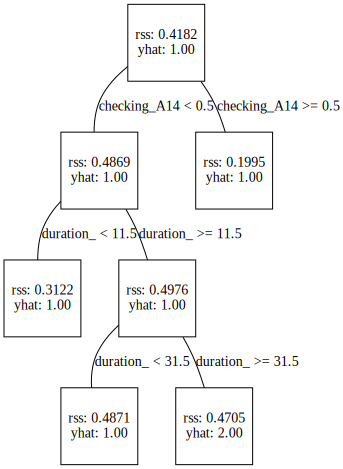

In [13]:
visualize_tree(pruned_tree)

# Evaluación del árbol

In [17]:
def _evaluate(tree, event):
    if tree['left'] == None and tree['right'] == None:
        return tree['yhat']
    if event[tree['x_j']] < tree['s']:
        return _evaluate(tree['left'], event)
    else:
        return _evaluate(tree['right'], event)

_evaluate(pruned_tree, gdat.iloc[0])

1

In [18]:
gdat['yhat'] = gdat.apply(lambda row: _evaluate(pruned_tree, row), axis=1)

In [24]:
gdat.is_good.head()

0    1
1    2
2    1
3    1
4    2
Name: is_good, dtype: int64

# Matriz de confución

In [31]:
(gdat[gdat.is_good == 2].yhat == 2).sum()

64

In [26]:
(gdat[gdat.is_good == 2].yhat == 1).sum()

204

In [27]:
(gdat[gdat.is_good == 1].yhat == 2).sum()

39

In [28]:
(gdat[gdat.is_good == 1].yhat == 1).sum()

593

In [29]:
64+204+39+593

900